
# Data processing and visualization for LV model

## 1. Combine data & calculate RMSE

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

days = 20
discretization = 1
obs_per_day = 12
nobs = days * obs_per_day

X = np.arange(0, days, 1./obs_per_day)
true_alpha = 0.6 + 0.3 * np.cos(6.28 * X / 10)
true_beta = 0.75 
true_delta = 1. 
true_gamma = 1 + 0.1 * np.sin(6.28 * X / 10)

all_alpha = np.zeros((100, days * obs_per_day))
all_gamma = np.zeros((100, days * obs_per_day))
all_beta = np.zeros(100)
all_delta = np.zeros(100)
all_xinit = np.zeros((100, 2))
for i in range(100):
    file = np.load('G:/TVMAGI-LV' + '/alpha_'+str(i)+'-dis=' + str(discretization) + '.npy')
    all_alpha[i] = file

for i in range(100):
    file = np.load('G:/TVMAGI-LV' + '/gamma_'+str(i)+'-dis=' + str(discretization) + '.npy')
    all_gamma[i] = file 
    
for i in range(100):
    file = np.load('G:/TVMAGI-LV' + '/beta_'+str(i)+'-dis=' + str(discretization) + '.npy')
    all_beta[i] = file  

for i in range(100):
    file = np.load('G:/TVMAGI-LV' + '/delta_'+str(i)+'-dis=' + str(discretization) + '.npy')
    all_delta[i] = file 

for i in range(100):
    file = np.load('G:/TVMAGI-LV' + '/xinit_'+str(i)+'-dis=' + str(discretization) + '.npy')
    all_xinit[i] = file
RMSE_alpha = np.sqrt(np.mean(np.square(all_alpha - true_alpha), axis=0))
print(np.mean(RMSE_alpha), np.std(RMSE_alpha))
RMSE_beta = np.abs(all_beta - true_beta)
print(np.mean(RMSE_beta), np.std(RMSE_beta))
RMSE_delta = np.abs(all_delta - true_delta)
print(np.mean(RMSE_delta), np.std(RMSE_delta))
RMSE_gamma = np.sqrt(np.mean(np.square(all_gamma - true_gamma), axis=0))
print(np.mean(RMSE_gamma), np.std(RMSE_gamma))

0.033405790676459546 0.032016910677180925
0.017504951168224342 0.010317150502530032
0.011952154705540452 0.00916568986345721
0.021411378243258495 0.01642370072306062


## 2. Reconstruct $x(t)$ using Gaussian process interpolation using trained $\theta$, initial x value and hyperparameters

In [ ]:
import pickle

def MaternKernel(d, phi_1, phi_2, nu=2.5):
    """
    construct a kernel given time points and hyper parameters
    """
    if nu == 2.5:  
        a = np.square(phi_1) * (
                1. + np.sqrt(5) * d / phi_2 + 5. * np.square(d) / (3. * np.square(phi_2))) * np.exp(
            -np.sqrt(5) * d / phi_2)
        return a
    elif nu == 1.5:
        a = np.square(phi_1) * (1. + np.sqrt(3) * d / phi_2) * np.exp(-np.sqrt(3) * d / phi_2)       
        return a
    else:
        raise ValueError

def GPinterp(x, y, phi_1, phi_2, inv_cov, days=20, obs_per_day=12):
    x_obs = np.arange(0, 20, 1 / obs_per_day)
    return y.T.dot(inv_cov).dot(MaternKernel(np.abs(x_obs - x), phi_1, phi_2, nu=2.5))
    

def recover_data(alpha, beta, delta, gamma, state0, days=20, obs_per_day=12, linspace=100, mode='Gaussian', hyper=None):
    """
    params: parameter: [beta, ve, vi, pd]
    """
    # check input
    # [ S, E, I, D, cfr0]
    global d_matrix
    nFull = int(days * obs_per_day)
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((nFull * linspace, 2))
    state_ls[0] = state0
    # Use linear interpolation for theta
    if mode == 'Linear': 
        x_initial = np.linspace(0, 1000, alpha.shape[0])
        x_interp = np.linspace(0, 1000, 24000)
        alpha_interp = np.interp(x_interp, x_initial, alpha)
        gamma_interp = np.interp(x_interp, x_initial, gamma)
    # Use Gaussian interpolation for theta    
    elif mode == 'Gaussian':
        alpha_interp = np.zeros(24000)
        gamma_interp = np.zeros(24000)
        alpha_inv_cov = np.linalg.inv(MaternKernel(d_matrix, hyper[0][0], hyper[0][1]))
        gamma_inv_cov = np.linalg.inv(MaternKernel(d_matrix, hyper[1][0], hyper[1][1]))
        for i in range(24000):
            alpha_interp[i] = GPinterp(i / (obs_per_day * linspace), alpha, hyper[0][0], hyper[0][1], alpha_inv_cov)
            gamma_interp[i] = GPinterp(i / (obs_per_day * linspace), gamma, hyper[1][0], hyper[1][1], gamma_inv_cov)
    else:
        raise ValueError
        
        
    for i in range(1, linspace * nFull):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha_interp[index] * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma_interp[index]  * state_ls[i - 1][1])
    return state_ls



n_points = days * discretization * obs_per_day
d_matrix = np.zeros((n_points, n_points))
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization) 
all_reconstructed_x = np.zeros((100, 24000, 2))
for i in range(100):
    print(i)
    file = open('G:/TVMAGI-LV/hyper_' + str(i) + '-dis=1.txt','rb')
    hyper_ls = pickle.load(file)
    all_reconstructed_x[i] = recover_data(all_alpha[i], all_beta[i], all_delta[i], all_gamma[i], all_xinit[i], mode='Gaussian', hyper=hyper_ls)

## 3. True value

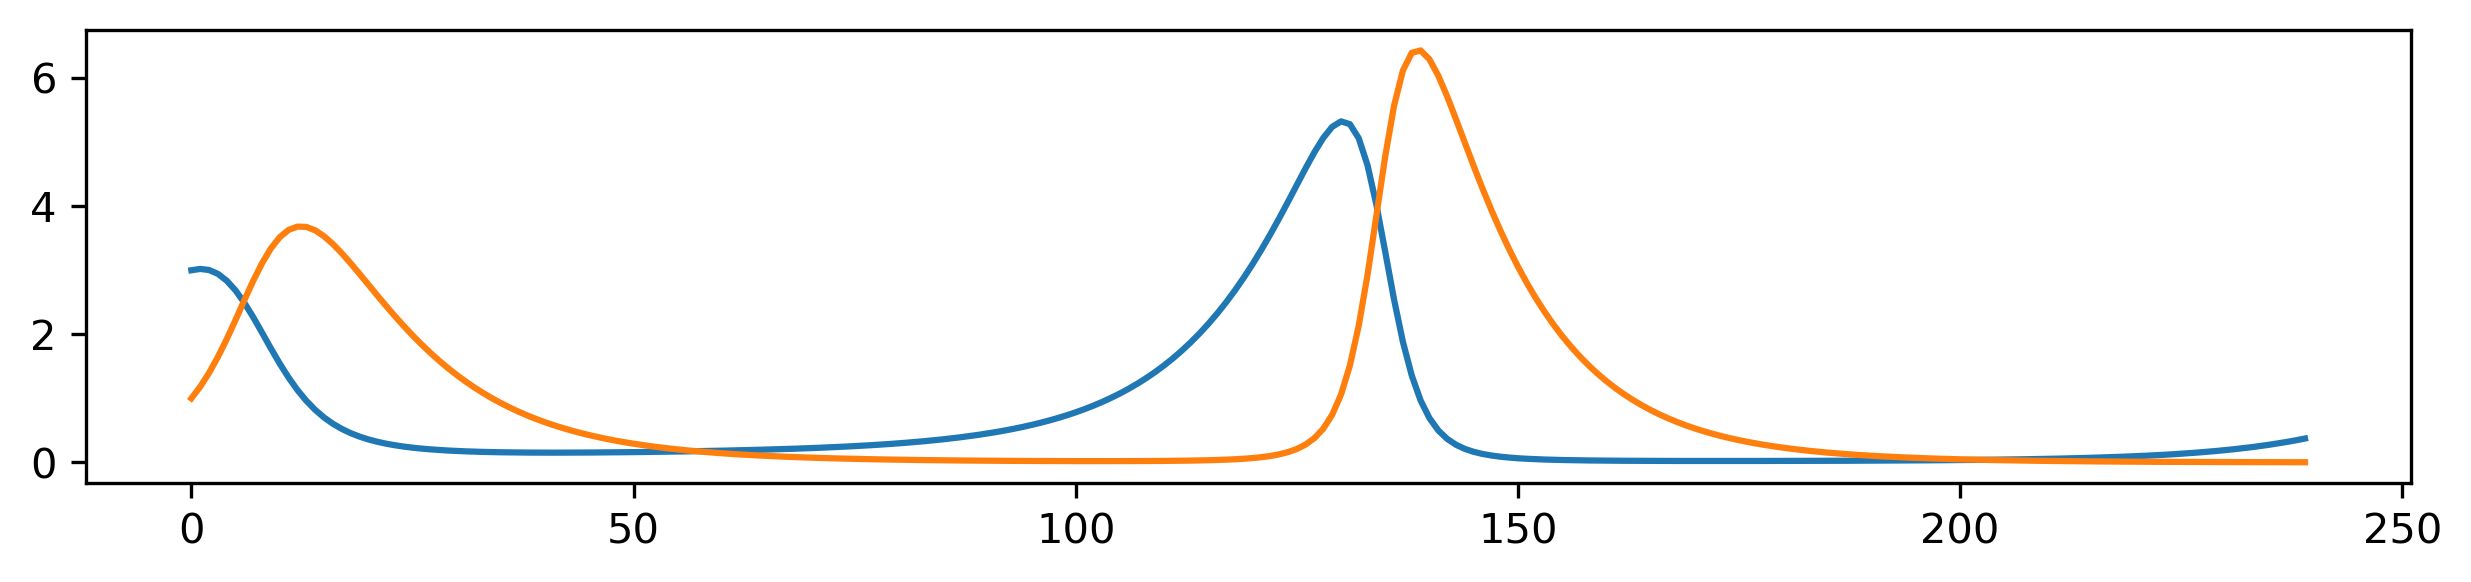

In [28]:
days = 20  
obs_per_day = 12
nobs = 240
X = np.arange(0, days, 1./(obs_per_day * 1000))
alpha = 0.6 + 0.3 * np.cos(6.28 * X / 10)
beta = 0.75 
delta = 1. 
gamma = 1 + 0.1 * np.sin(6.28 * X / 10)
theta_true = np.vstack([alpha, gamma]).T

# data generation for 20 years with monthly observations
def recover_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[3., 1.], linspace=1000, noise=True):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha[index] * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]

    return states

true_x = recover_data(alpha, beta, delta, gamma, days, obs_per_day)
plt.plot(true_x[:, 0])
plt.plot(true_x[:, 1])

## 4. Visualization

Text(0.5, 1.0, 'Predator')

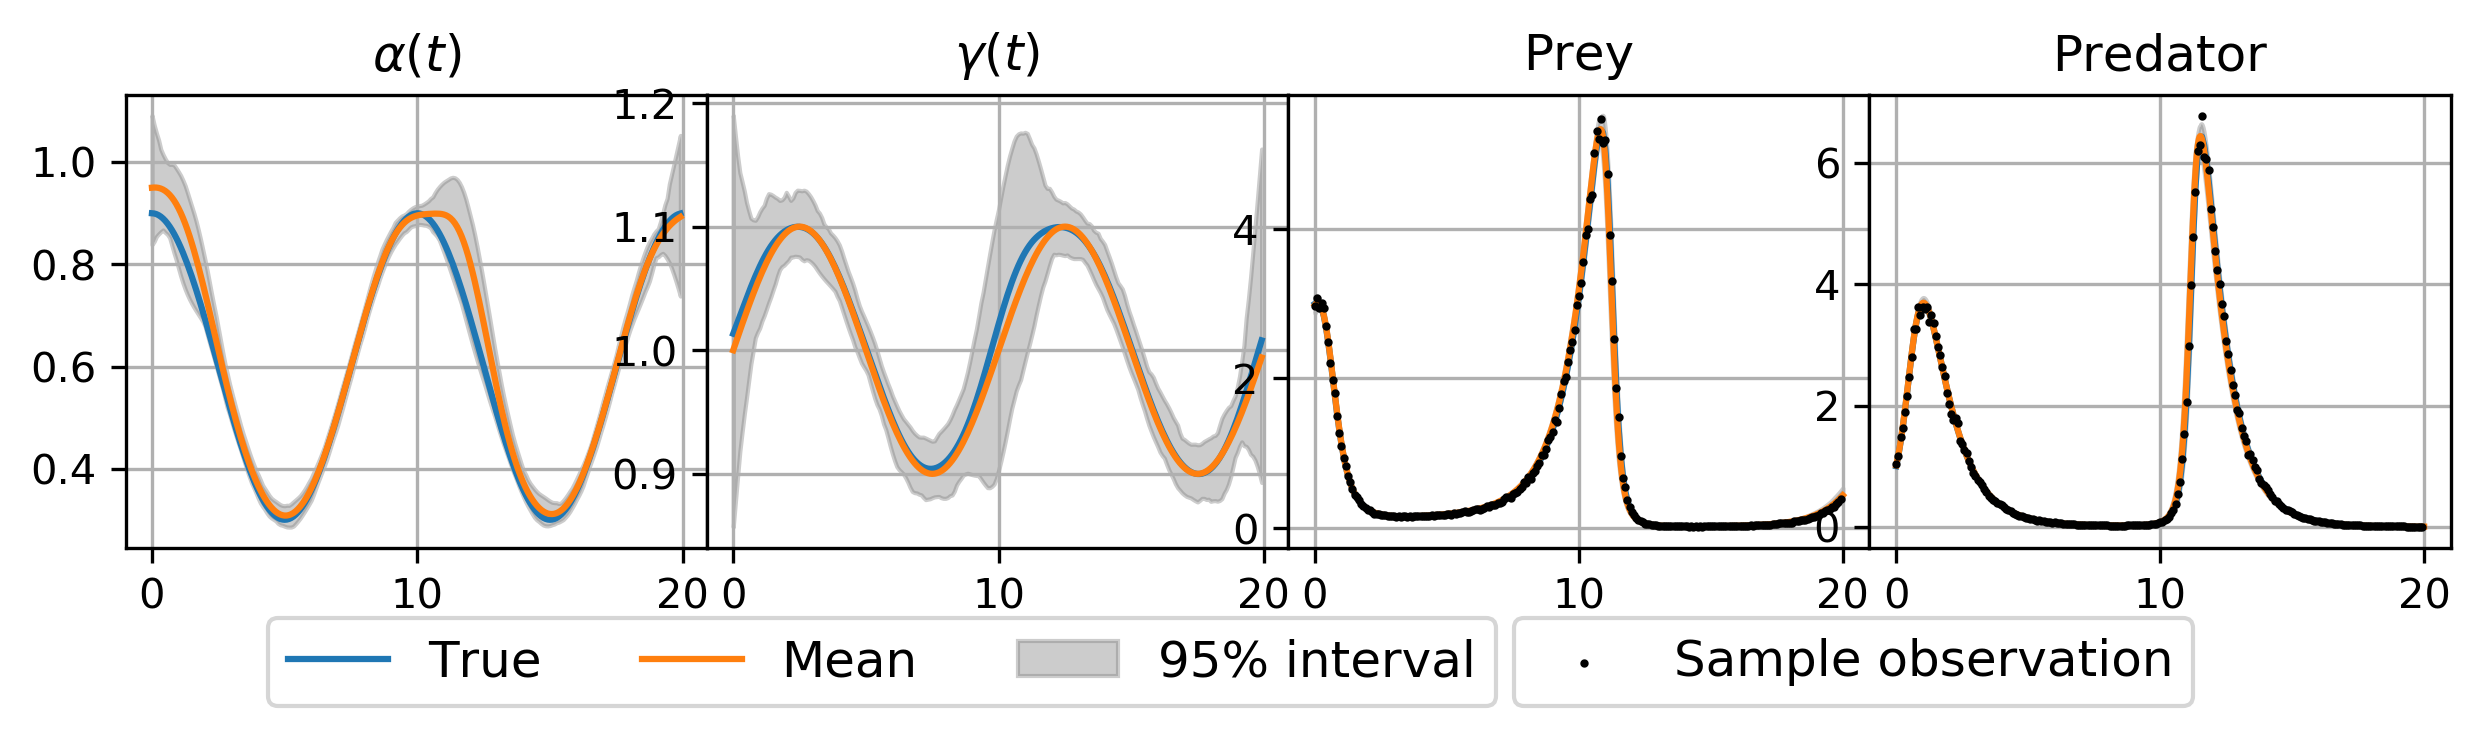

In [47]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # set figsize
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

figsize(10, 2)
plt.subplots_adjust(wspace =0, hspace =0)
ax1 = plt.subplot(1, 4, 1) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_alpha, 97.5, axis=0)
upper_95 = np.percentile(all_alpha, 2.5, axis=0)
x = np.arange(0, days, 1 / obs_per_day)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4, label='95% interval')
plt.plot(x, true_alpha, label='True')
plt.plot(x, np.mean(all_alpha, axis=0), label='Mean')
plt.title(r'$\alpha(t)$')
plt.grid()
plt.legend(bbox_to_anchor=(2.4, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 2)
lower_95 = np.percentile(all_gamma, 97.5, axis=0)
upper_95 = np.percentile(all_gamma, 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(x, np.mean(all_gamma, axis=0))
plt.plot(x, true_gamma)
plt.grid()
plt.title(r'$\gamma(t)$')

yobs = np.load('G:/TVMAGI-LV/LV observations.npy')[1]
ax1 = plt.subplot(1, 4, 3) # 两行一列，位置是1的子图
lower_95 = np.percentile(all_reconstructed_x[:,:, 0], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 0], 2.5, axis=0)
x = np.arange(0, 20, 1 / (obs_per_day * 100))
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, 20, 1 / obs_per_day), true_x[:, 0])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 0], axis=0))
plt.scatter(np.arange(0, 20, 1 / obs_per_day), yobs[:, 0], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title('Prey')
plt.legend(bbox_to_anchor=(1.6, -0.1), fontsize=12, ncol=4)

ax2 = plt.subplot(1, 4, 4)
lower_95 = np.percentile(all_reconstructed_x[:,:, 1], 97.5, axis=0)
upper_95 = np.percentile(all_reconstructed_x[:,:, 1], 2.5, axis=0)
plt.fill_between(x, lower_95, upper_95, color='grey', alpha = 0.4)
plt.plot(np.arange(0, 20, 1 / obs_per_day), true_x[:, 1])
plt.plot(x, np.mean(all_reconstructed_x[:,:, 1], axis=0))
plt.scatter(np.arange(0, 20, 1 / obs_per_day), yobs[:, 1], s = 1, color='black', label='Sample observation', zorder=100)
plt.grid()
plt.title('Predator')

## 5. RMSE of $x(t)$

In [48]:
linspace = 100
RMSE_R = np.zeros(100)
RMSE_F = np.zeros(100)
for i in range(100):
    RMSE_R[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::linspace, 0] - true_x[:, 0])))
    RMSE_F[i] = np.sqrt(np.mean(np.square(all_reconstructed_x[i, ::linspace, 1] - true_x[:, 1])))
    
print(np.mean(RMSE_R), np.std(RMSE_R))
print(np.mean(RMSE_F), np.std(RMSE_F))

0.06663904240606802 0.0392351359397423
0.08463523511171572 0.05109081065933345
